# Multi-Objectives Robust Optimisation (MORO)

Group 11, *EPA1361 Model-based Decision-making 18/19*

A. Werntges, H. Cheng, G. Papazotos, R. Patel, P. De Biase

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
from ema_workbench import (MultiprocessingEvaluator,
                           Scenario, Constraint, Policy,
                           ScalarOutcome)
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from ema_workbench.em_framework.evaluators import (perform_experiments, optimize,
                                                   BaseEvaluator)
from ema_workbench.em_framework import sample_uncertainties
from ema_workbench.util import ema_logging, save_results, load_results
from ema_workbench.analysis import (pairs_plotting, prim, 
                                    feature_scoring, parcoords,
                                    dimensional_stacking, plotting)
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType

from model.problem_formulation import get_model_for_problem_formulation
%matplotlib inline
sns.set_style('white')

ema_logging.log_to_stderr(ema_logging.INFO)
np.random.seed(42)
random.seed(42)

C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
'''
For different list of outcomes:
# 0 = 2-objective PF
# 1 = 3-objective PF
# 2 = 5-objective PF
# 3 = Disaggregate over locations
# 4 = Disaggregate over time
# 5 = Fully disaggregated
'''
ID_PF = 2    # assign problem_formulation_id
NR_STEPS = 2 # assign number of planning steps
dike_model, planning_steps = get_model_for_problem_formulation(ID_PF, NR_STEPS)

# Define the robustness metrics

The robustness metric chosen for dike costs, RfR costs and evaciation costs is the mean absolute performance across the set of scenarios. For the expected annual damage and expected number of deaths the robustness metric is the percentage of scenarios where the outcome is below a certain threshold. 

In [3]:
import functools

def mean_rob(data):
    return np.sum(data)/(data.shape[0]*1e9)

def threshold(direction, threshold, data):
    if direction == "SMALLER":
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]

death_funcs = functools.partial(threshold, "SMALLER", 0.00001)
damage_funcs = functools.partial(threshold, "SMALLER", 10000)

robustness_functions = [ScalarOutcome('Robustness metric Damage', kind=ScalarOutcome.MAXIMIZE,
                                      variable_name='Expected Annual Damage', function = damage_funcs),
                        ScalarOutcome('Robustness metric Dike Costs', kind=ScalarOutcome.MINIMIZE,
                                      variable_name='Dike Investment Costs', function = mean_rob),
                        ScalarOutcome('Robustness metric RfR Costs', kind=ScalarOutcome.MINIMIZE,
                                      variable_name='RfR Investment Costs', function = mean_rob),
                        ScalarOutcome('Robustness metric Evacuation Costs', kind=ScalarOutcome.MINIMIZE,
                                      variable_name='Evacuation Costs', function = mean_rob),
                        ScalarOutcome('Robustness metric Deaths', kind=ScalarOutcome.MAXIMIZE,
                                      variable_name='Expected Number of Deaths', function = death_funcs)]

## Check the number of scenarios needed

In this section the number of scenarios needed for the robustness metrics to stabilize. 

In [12]:
'''LOAD RESULTS FROM:
#
# with MultiprocessingEvaluator(dike_model) as evaluator:
#     results = evaluator.perform_experiments(scenarios=1000, policies=10) # using lhs sampling 
#
'''
results = load_results('./results/open_exploration_uncertainties_10000runs_2steps.tar.gz')

experiments, outcomes = results

[MainProcess/INFO] results loaded succesfully from D:\EPA\EPA Semester-1.4\EPA1361 Model-based Decision-making\MBDM-group-11\final assignment\results\open_exploration_uncertainties_10000runs_2steps.tar.gz


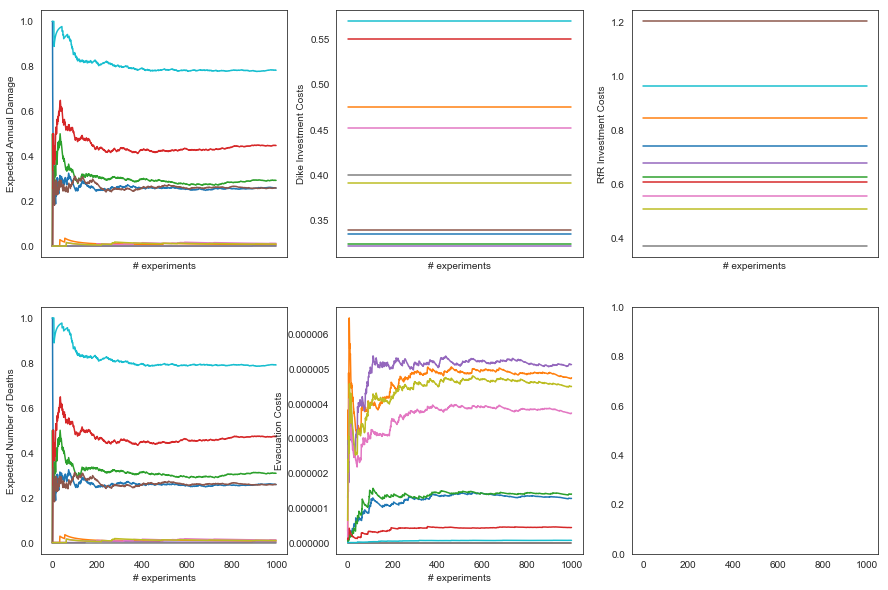

In [19]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15,10), sharex=True)
axes = [axes[0, 0], axes[0, 1], axes[0, 2], 
        axes[1, 1], axes[1, 0], _]  

robustness_funcs = {"Expected Number of Deaths": death_funcs,
                    "Expected Annual Damage": damage_funcs, 
                    "RfR Investment Costs": mean_rob,
                    "Evacuation Costs": mean_rob,
                    "Dike Investment Costs": mean_rob}

for ax, (outcome, value) in zip(axes, outcomes.items()):
    for policy in np.unique(experiments['policy']):
        logical = experiments['policy'] == policy
        data = value[logical]
        
        robustness = []
      
        for i in range(1, data.shape[0]):
            robustness.append(robustness_funcs[outcome](data[0:i]))
        ax.plot(robustness, label=policy)
    ax.set_xlabel("# experiments")
    ax.set_ylabel(outcome)

## Perform MORO

In [14]:
NFE = 17500
NR_SCENARIO = 100
scenarios = sample_uncertainties(dike_model, NR_SCENARIO)
epsilons = [0.01, 0.01, 0.01, 0.01, 0.01]

In [9]:
BaseEvaluator.reporting_frequency = 15

convergence_metrics = [HyperVolume(minimum = [0, 0, 0, 0, 0], 
                                   maximum = [1.1, 3, 3, 3, 1.1]),
                       EpsilonProgress()]
 
constraint = [Constraint("Death constraint", outcome_names="Robustness metric Deaths", 
                         function=lambda x: max(0, 0.75-x))]

In [11]:
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.robust_optimize(robustness_functions, scenarios, nfe=NFE, 
                                        convergence=convergence_metrics, 
                                        epsilons=epsilons, constraints=constraint,
                                        convergence_freq=10)

In [16]:
results = load_results("./results/robust_optimization_17500nfe.tar")

archive, convergence = results

[MainProcess/INFO] results loaded succesfully from D:\EPA\EPA Semester-1.4\EPA1361 Model-based Decision-making\MBDM-group-11\final assignment\results\robust_optimization_17500nfe.tar


## Convergence of ε and hypervolume

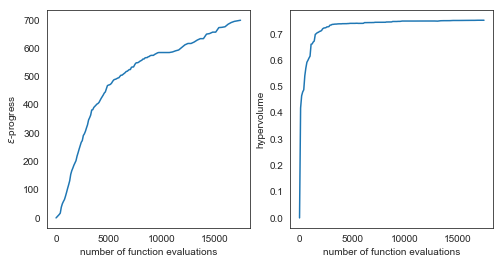

In [17]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence['nfe'], convergence['epsilon_progress'])
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence['nfe'], convergence['hypervolume'])
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()